In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from datetime  import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error as mae
import io

In [15]:
df = pd.read_csv('./complete_dataset.csv')
df.head()

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


In [16]:
df['date']=pd.to_datetime(df['date'])
df.rainfall.fillna(df.rainfall.median(), inplace=True) 

df.solar_exposure.fillna(df.solar_exposure.median(), inplace=True) 

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2106 non-null   datetime64[ns]
 1   demand           2106 non-null   float64       
 2   RRP              2106 non-null   float64       
 3   demand_pos_RRP   2106 non-null   float64       
 4   RRP_positive     2106 non-null   float64       
 5   demand_neg_RRP   2106 non-null   float64       
 6   RRP_negative     2106 non-null   float64       
 7   frac_at_neg_RRP  2106 non-null   float64       
 8   min_temperature  2106 non-null   float64       
 9   max_temperature  2106 non-null   float64       
 10  solar_exposure   2106 non-null   float64       
 11  rainfall         2106 non-null   float64       
 12  school_day       2106 non-null   object        
 13  holiday          2106 non-null   object        
dtypes: datetime64[ns](1), float64(11), objec

In [18]:
df.isna().sum()

date               0
demand             0
RRP                0
demand_pos_RRP     0
RRP_positive       0
demand_neg_RRP     0
RRP_negative       0
frac_at_neg_RRP    0
min_temperature    0
max_temperature    0
solar_exposure     0
rainfall           0
school_day         0
holiday            0
dtype: int64

In [19]:
df_1=df.copy()

#Setting the quantile range
Q1 = df_1['RRP'].quantile(0.25)
Q3 = df_1['RRP'].quantile(0.75)
IQR = Q3 - Q1 

#Roming the outliers
df_1 = df_1[(df_1['RRP'] > (Q1 - 1.5 * IQR)) & (df_1['RRP'] < (Q3 + 1.5 * IQR))]

In [20]:
norm_scale=MinMaxScaler()
df_scaled=norm_scale.fit_transform(df_1[['RRP','demand','demand_pos_RRP', 'demand_neg_RRP', 'min_temperature',
                                         'max_temperature', 'solar_exposure', 'rainfall']])
df_scaled=pd.DataFrame(df_scaled, columns=['RRP','demand','demand_pos_RRP', 'demand_neg_RRP', 'min_temperature',
                                           'max_temperature', 'solar_exposure', 'rainfall'])

In [21]:
df_scaled['date']=df_1['date']
df_scaled['holiday']=df_1['holiday']
df_scaled['school_day']=df_1['school_day']

In [22]:
df_scaled=pd.get_dummies(df_scaled)

In [23]:
df_ready=df_scaled.dropna()

Training

In [24]:
df_train = df_ready[df_ready.date<='2019-01-01']
#Test dataset
df_test =  df_ready[df_ready.date>'2019-01-01']
#A reserved copy of the test dataset for plotting
df_resid = df_ready[df_ready.date>'2019-01-01']

#Extract the target feature for training and testing
y_train=df_train["RRP"]
y_test=df_test["RRP"]

#Extracting the independent features for training and testing
X_train =df_train.drop(labels=['RRP', 'date'], axis=1)
X_test=df_test.drop(labels=['RRP', 'date'], axis=1)
df_train.shape

(1451, 13)

In [25]:
reg = RandomForestRegressor()
reg.fit(X_train, y_train)
ypred=reg.predict(X_test)

len(ypred)

599

In [27]:
df_resid['y_pred1']=ypred
df_resid=df_resid.set_index('date')

C:\Users\ishan\AppData\Local\Temp\ipykernel_14768\3089618082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resid['y_pred1']=ypred


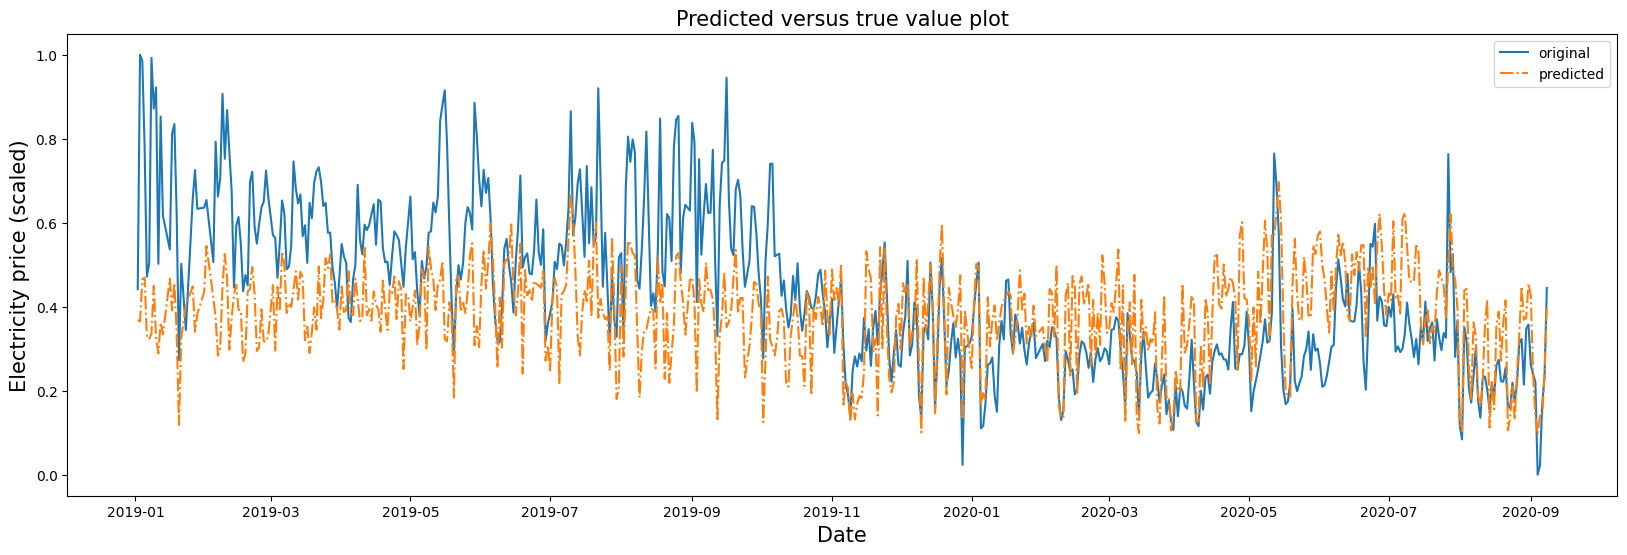

In [28]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=df_resid, x='date', y='RRP', label="original")
sns.lineplot(data=df_resid, x='date', y="y_pred1", linestyle= 'dashdot', label="predicted")
plt.title("Predicted versus true value plot", fontsize=15)
plt.ylabel('Electricity price (scaled)', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.legend()
plt.show()

Testing

In [29]:
mse = mean_squared_error(y_test, ypred)
print("MSE:",  mse)
#Mean absolute error
MAE=mae(y_test, ypred)

#Root mean squared error
rmse = np.sqrt(mse)

print("RMSE:", rmse)
print("mae:", MAE)

MSE: 0.03382085589168491
RMSE: 0.18390447490935316
mae: 0.14110306135591458


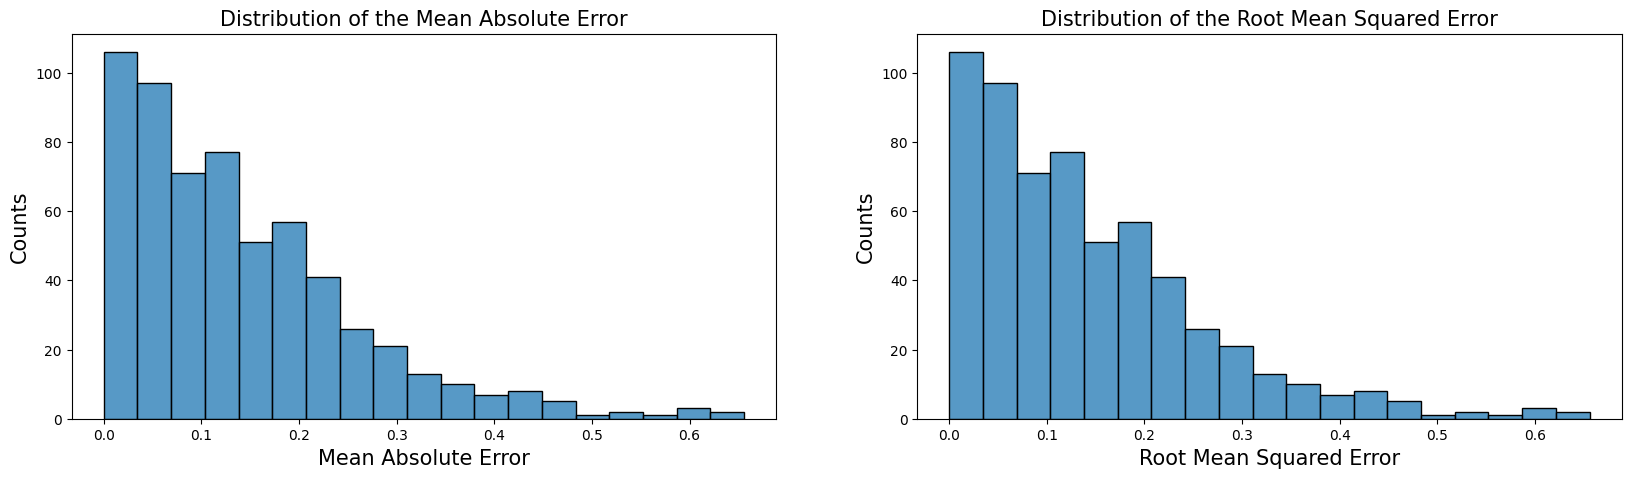

In [30]:
expected = np.array(y_test)
# predicted value
predicted = ypred
# calculate errors
MAE_errors = list()
MSE_errors=list()
for i in range(len(expected)):
# calculate error
    
    err = abs((expected[i] - predicted[i]))
    err2=(expected[i] - predicted[i])**2
# store error
    MAE_errors.append(err)
    MSE_errors.append(err2)
    
    
#Plotting error distributions
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.histplot(MAE_errors)
plt.xlabel('Mean Absolute Error', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Distribution of the Mean Absolute Error', fontsize=15)

plt.subplot(1,2,2)
sns.histplot(np.sqrt(MSE_errors))
plt.xlabel('Root Mean Squared Error', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Distribution of the Root Mean Squared Error', fontsize=15)
plt.show()

Validation

In [32]:
tscv = TimeSeriesSplit(n_splits = 5)
rmse = []
MAE=[]
MSE=[]
for train_index, test_index in tscv.split(df_ready):
    df_train, df_test = df_ready.iloc[train_index], df_ready.iloc[test_index]
    X_train =df_train.drop(labels=['RRP', 'date'], axis=1)
    X_test=df_test.drop(labels=['RRP', 'date'], axis=1)
    y_train=df_train["RRP"]
    y_test=df_test["RRP"]
    reg=RandomForestRegressor()
    reg.fit(X_train, y_train)
    predictions = reg.predict(X_test)
    true_values = y_test.values
    MSE.append(mean_squared_error(true_values, predictions))
    MAE.append(mae(true_values, predictions))
    rmse.append(np.sqrt(mean_squared_error(true_values, predictions)))
    
    
print("RMSE_avrg: {}".format(np.mean(rmse)))
print("MSE_avrg: {}".format(np.mean(MSE)))
print("MAE_avrg: {}".format(np.mean(MAE)))
dict_met={'Split':['1', '2', '3', '4', '5'],'RMSE':rmse, 'MAE':MAE, 'MSE':MSE}
metric=pd.DataFrame(dict_met)
metric=metric.set_index('Split')
metric

RMSE_avrg: 0.20991257004970548
MSE_avrg: 0.04733859186319422
MAE_avrg: 0.17090034435071763


,RMSE,MAE,MSE
Split,,,
1,0.164436,0.103326,0.027039
2,0.302842,0.268772,0.091713
3,0.196797,0.159142,0.038729
4,0.242297,0.206512,0.058708
5,0.143190,0.116750,0.020503
